<a href="https://colab.research.google.com/github/zhukuixi/Fastai/blob/main/fastat_lesson3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 拟合三次函数的例子


In [3]:
from fastai.vision.all import *
from functools import partial
import numpy as np

from ipywidgets import interact
from fastai.basics import *



## 建立函数方程，用partial技巧完成参数可互动调节来改善拟合的可视化

In [4]:
def f(a,b,c,d,x):
  return a*x**3+b*x**2+c*x+d

def partial_f(a,b,c,d):
  return partial(f,a,b,c,d)

def mse(predValue,trueValue):
  return F.mse_loss(predValue,trueValue).sqrt()


In [5]:
def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100).unsqueeze(1)
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

真实模型的参数设置，画出函数曲线图


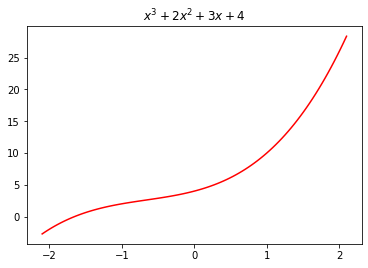

In [6]:
plot_function(partial_f(1,2,3,4),title="$x^3+2x^2+3x+4$")

x轴抽样20个点，加入噪音，完成syntheic data的绘制


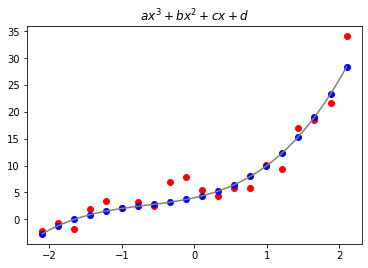

In [7]:
x = torch.linspace(-2.1,2.1,20).unsqueeze(1)
y = f(1,2,3,4,x)
torch.random.manual_seed(1897)
y_noise = y*(1.0+torch.randn(size=y.shape)*0.15) + torch.randn(size=y.shape)*1.5

plt.scatter(x,y_noise,color="red")
plt.scatter(x,y,color="blue")
plot_function(partial_f(1,2,3,4),title="$ax^3+bx^2+cx+d$",color="grey")

In [8]:
@interact(a=2.0, b=2.0, c=2.0,d=2.0)
def plot_quad(a, b, c,d):
    plt.scatter(x,y_noise,color="red")
    predValue = partial_f(a,b,c,d)(x)
    mseValue = mse(predValue,y_noise)
    plot_function(partial_f(a,b,c,d), ylim=(-15,30),title=f"${a}x^3+{b}x^2+{c}x+{d}$"+f" mse:{mseValue:0.3f}",color="grey")
    plt.plot(x,y,color="blue")

interactive(children=(FloatSlider(value=2.0, description='a', max=6.0, min=-2.0), FloatSlider(value=2.0, descr…

## 梯度下降的实现

In [9]:
def init_para(size,std=1.0):
  return (torch.randn(size)*std).requires_grad_()

In [30]:
lr = 0.1
torch.random.manual_seed(1897)
paras = init_para((4,1))
for i in range(20):
  predValue = partial_f(*paras)(x)
  loss = mse(predValue,y_noise) 
  loss.backward()
  paras.data -= paras.grad*lr
  paras.grad.zero_()
  print(f"epoch:{i} loss:{loss:.3f}")



epoch:0 loss:12.135
epoch:1 loss:11.124
epoch:2 loss:10.186
epoch:3 loss:9.325
epoch:4 loss:8.540
epoch:5 loss:7.828
epoch:6 loss:7.184
epoch:7 loss:6.599
epoch:8 loss:6.065
epoch:9 loss:5.574
epoch:10 loss:5.119
epoch:11 loss:4.696
epoch:12 loss:4.303
epoch:13 loss:3.942
epoch:14 loss:3.615
epoch:15 loss:3.326
epoch:16 loss:3.079
epoch:17 loss:2.875
epoch:18 loss:2.713
epoch:19 loss:2.591


# MNIST的例子
这里是个区分数字7和3的二分任务。  
* 一开始的想法是利用pixel similarity.也即找到所有标签为6(9)的图像，制造一张平均图。然后面对新的样本，比较这个样本和6与9的平均图的距离。  
* 然后我们用NN的SGD来实现。一开始是low level coding实现，然后是high level coding实现.

## MNIST的方案1：Pixel Similarity

In [11]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train')]

In [12]:
threeTrainFiles = (path/'train/3').ls()
sevenTrainFiles = (path/'train/7').ls()
threeValidFiles = (path/'valid/3').ls()
sevenValidFiles = (path/'valid/7').ls()

In [13]:
im3 = Image.open(threeTrainFiles[0])
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,29,108,86,128,181,181,252,239,155,56,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,70,233,254,254,254,254,254,254,254,254,235,63,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,10,100,246,254,254,225,154,82,20,7,7,115,254,128,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,152,254,254,254,209,30,0,0,0,0,0,89,254,195,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,112,251,244,254,254,233,51,0,0,0,21,192,254,99,0,0,0,0,0,0,0


### 收集train set里头3和7的图片，并计算平均值图片

In [14]:
threeTrainTensor = torch.stack([tensor(Image.open(f)) for f in threeTrainFiles]).float()/255
sevenTrainTensor = torch.stack([tensor(Image.open(f)) for f in sevenTrainFiles]).float()/255

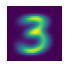

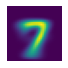

In [15]:
mean3 = threeTrainTensor.mean(0)
mean7 = sevenTrainTensor.mean(0)

show_image(mean3)
show_image(mean7)

In [16]:
threeValidTensor = torch.stack([tensor(Image.open(f)) for f in threeValidFiles]).float()/255
sevenValidTensor = torch.stack([tensor(Image.open(f)) for f in sevenValidFiles]).float()/255

In [17]:
validData_Y = tensor([0]*len(threeValidFiles)+[1]*len(sevenValidFiles))
validData_X = torch.cat([threeValidTensor,sevenValidTensor],axis=0)
validData = list(zip(validData_X,validData_Y))

In [18]:
def dist_mean3(sample):
  return F.mse_loss(sample,mean3)

def dist_mean7(sample):
  return F.mse_loss(sample,mean7)

In [19]:
predictResult  = tensor([0 if dist_mean3(sample[0])<dist_mean7(sample[0]) else 1 for sample in validData])


In [20]:
accuracy = (predictResult==validData_Y).float().mean()
print(f"The accuracy of pixel similarty based is {accuracy:.3f}")

The accuracy of pixel similarty based is 0.966


## MNIST的方案2：SGD

In [21]:

# loss function
def mnist_loss(predValue,trueValue):
  return torch.where(trueValue==1,1-predValue,predValue).mean()
# validation metric for one batch
def batch_accuracy(predValue,trueValue):
  return (torch.where(predValue>0.5,1,0)==trueValue).float().mean()


# Make DataLoader for training and valid dataset
trainData_X = torch.cat([threeTrainTensor,sevenTrainTensor],axis=0).view(-1,28*28)
trainData_Y = tensor([0]*len(threeTrainFiles)+[1]*len(sevenTrainFiles)).unsqueeze(1)

validData_X = torch.cat([threeValidTensor,sevenValidTensor],axis=0).view(-1,28*28)
validData_Y = tensor([0]*len(threeValidFiles)+[1]*len(sevenValidFiles)).unsqueeze(1)

trainData = list(zip(trainData_X,trainData_Y))
validData = list(zip(validData_X,validData_Y))
trainDataLoader = DataLoader(trainData,batch_size=256,shuffle=True)
validDataLoader = DataLoader(validData,batch_size=256,shuffle=True)




### low level 写法

In [31]:

# model framework
def model(x):
  layer1_input = x@w1+bias1
  layer1_output = F.relu(layer1_input)
  layer2_input = layer1_output@w2+bias2
  layer2_output = torch.sigmoid(layer2_input)
  return layer2_output
  
# validation metric for one epoch
def validation_epoch(model):
  return torch.stack([batch_accuracy(model(x),y) for x,y in validDataLoader]).mean().item()

# Initialize parameters
torch.random.manual_seed(1897)
w1 = init_para((28*28,30))
bias1 = init_para(30)
w2 = init_para((30,1))
bias2 = init_para(1)

# learning 
def learning():
  lr = 1
  for epoch in range(20):
    for x,y in trainDataLoader:    
      # compute gradient
      pred = model(x)     
      loss = mnist_loss(pred,y)
      loss.backward()
      # update parameter
      w1.data -= w1.grad*lr
      bias1.data -= bias1.grad*lr      
      w1.grad.zero_()
      bias1.grad.zero_()  
    # check the performance on validation and loss on training for each epoch
    valiAcc = validation_epoch(model)      
    print(f"epoch:{epoch} validation accuracy:{valiAcc:.4f}")
   


In [32]:
learning()

epoch:0 validation accuracy:0.9043
epoch:1 validation accuracy:0.9466
epoch:2 validation accuracy:0.9574
epoch:3 validation accuracy:0.9627
epoch:4 validation accuracy:0.9670
epoch:5 validation accuracy:0.9681
epoch:6 validation accuracy:0.9720
epoch:7 validation accuracy:0.9706
epoch:8 validation accuracy:0.9715
epoch:9 validation accuracy:0.9740
epoch:10 validation accuracy:0.9745
epoch:11 validation accuracy:0.9744
epoch:12 validation accuracy:0.9745
epoch:13 validation accuracy:0.9745
epoch:14 validation accuracy:0.9764
epoch:15 validation accuracy:0.9745
epoch:16 validation accuracy:0.9765
epoch:17 validation accuracy:0.9755
epoch:18 validation accuracy:0.9764
epoch:19 validation accuracy:0.9779


### High Level写法 (fastai api)

In [24]:

dls = DataLoaders(trainDataLoader,validDataLoader)

simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1),
    nn.Sigmoid()
)
# mnist_loss和batch_accuracy是之前自定义的函数
learn = Learner(dls,simple_net,opt_func=SGD,loss_func=mnist_loss,metrics=batch_accuracy)
learn.fit(40,0.1)


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.247758,0.098067,0.964671,00:00
1,0.116069,0.055799,0.967615,00:00
2,0.069591,0.045364,0.968597,00:00
3,0.049640,0.040283,0.970069,00:00
4,0.039826,0.037194,0.971541,00:00
5,0.034198,0.034918,0.972522,00:00
6,0.030990,0.033339,0.974975,00:00
7,0.028652,0.032072,0.975466,00:00
8,0.026760,0.030833,0.976448,00:00
9,0.025723,0.029940,0.976448,00:00


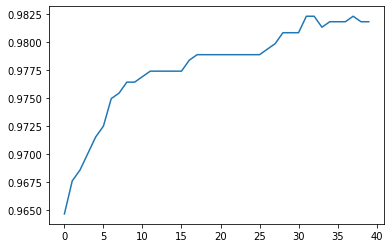

In [25]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [26]:
learn.recorder.values[-1][2]

0.981844961643219